In [1]:
# Common stuff reused by all applications
from analysis_common import *
%matplotlib inline


EXPERIMENT_SIZE_FIELDS = [
    "number_of_fragments",
    "points_per_fragment", 
]

PLATFORM_FIELDS = [
    "nodes",
    "cpus_per_node",
    "backends_per_node",
    "dataclay",
    "use_split",
]

HANDPICKED_OUTLIERS = [
    # A lot of those seem to be for the executions done during 15th june at 7am. 
    # 6am executions were still fine.
    # Temperature issues? General jitter? Sysadmin updating the system?
    # We may never know
    23429588, 23424157, 23424125, 23505880, 23505871, 23505863, 23429586, 23505895, 23505868,
    23505904, 23505912, 23505886, 23505860,
    23505887, 23505892, 23505915, 23505913, 23505864,
    23503326, 23503411, 23429587, 23505920, 23505865,
    23429586, 23414331, 23414325,
    23424174, 23424176,
    23429575,
    23505894,
    23756636, 23503291, 23503143, 23424197, 23424199,
]

In [2]:
db = DataStorage("kmeans-split")
df = prepare_df(db, HANDPICKED_OUTLIERS)

df.query("start_ts > '2022-06-09'", inplace=True)

df.drop(df[(df['id'] < 27719936) & (df['dask'] == 1)].index, inplace=True)
df.drop(df[(df['id'] < 28231260) & (df['dask'] == 1) & (df["use_split"] == 1)].index, inplace=True)

In [3]:
edf = df.explode("iteration_time").sort_values('mode')
edf['iteration_time'] = edf['iteration_time'].astype(float)
winsorize_edf(edf, "iteration_time", ["mode", "nodes","points_per_fragment", "number_of_fragments"])

/home/alex/BSC/split-miniapps/analysis/analysis_common.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df[mask] = mstats.winsorize(working_df[mask], limits=[0, 0.3])


# Weak scaling (small blocks)

- 2304 fragments **per node**
- 128000 points per fragment

This shows the behaviour of split in a typical scalability environment. The quantity of objects is high and increases with the number of nodes. The benefits of the split should be more apparent as the number of nodes / work increases.

/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


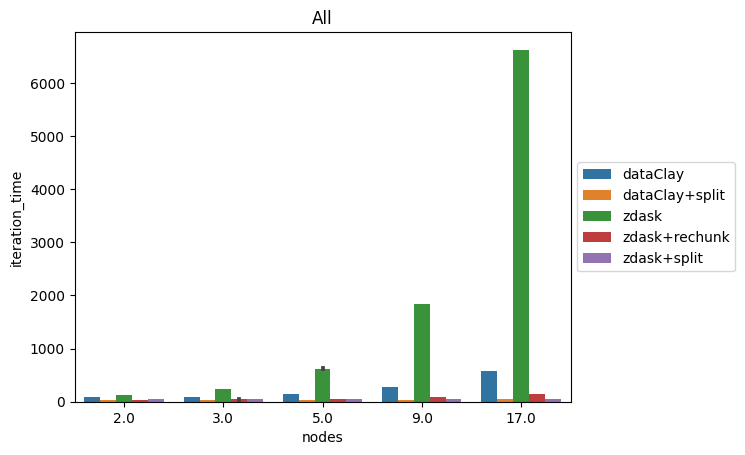

<Figure size 640x480 with 0 Axes>

/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


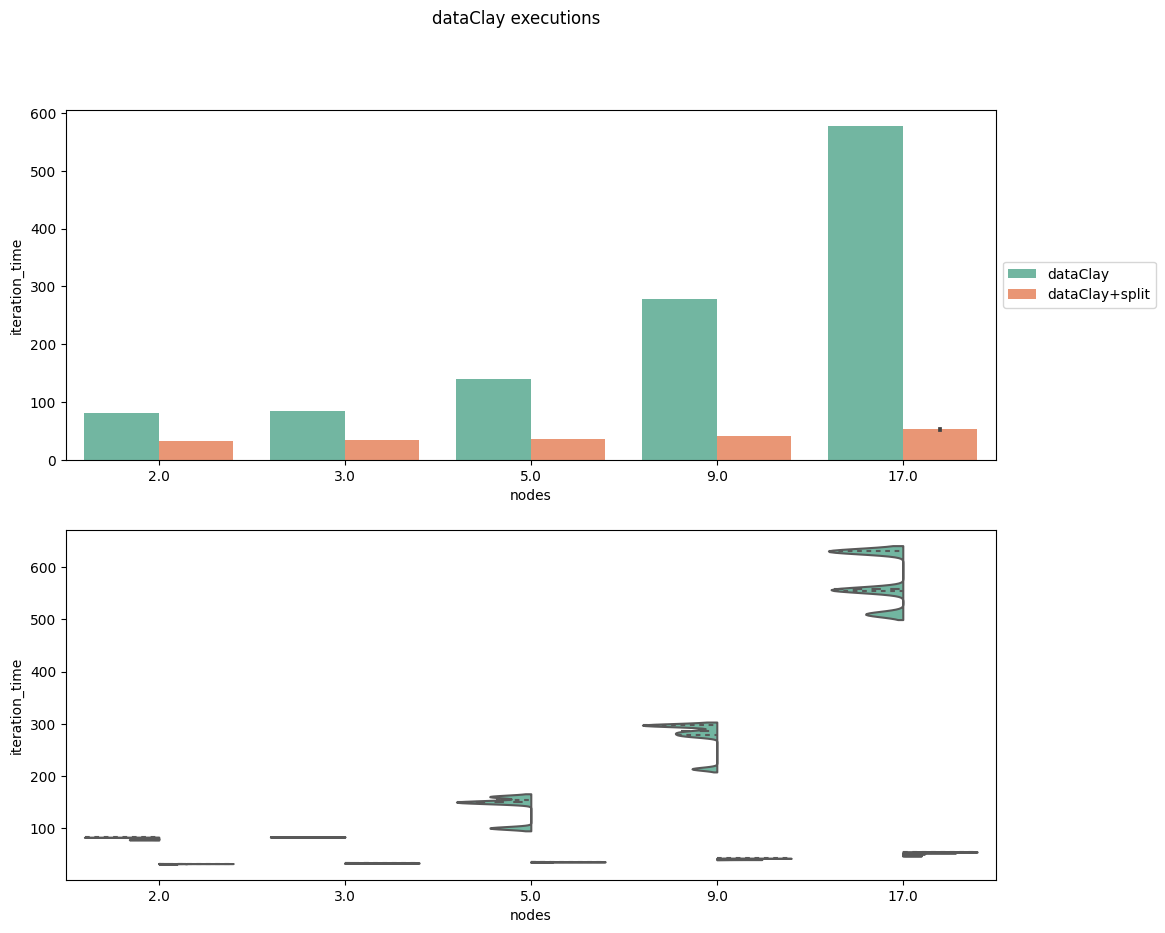

initialization_time  iteration_time
nodes mode                                               
2.0   dataClay                  59.893290       81.128383
      dataClay+split            60.259005       32.476223
      zdask                      3.164331      129.912008
      zdask+rechunk              3.159377       33.911576
      zdask+split                3.474033       42.766860
3.0   dataClay                  85.375222       83.600312
      dataClay+split            75.331375       33.525675
      zdask                      3.765959      233.186893
      zdask+rechunk              3.742033       42.134194
      zdask+split                4.033626       43.262707
5.0   dataClay                 205.879229      140.487633
      dataClay+split           136.966086       35.724485
      zdask                      4.675352      622.806071
      zdask+rechunk              4.662655       49.885066
      zdask+split                5.256486       44.609765
9.0   dataClay                 322.611034      278.632099
      dataClay+split           265.290424       41.423162
      zdask                      7.020823     1838.948725
      zdask+rechunk              7.135400       88.327631
      zdask+split                8.523644       46.259171
17.0  dataClay                 530.945222      577.079918
      dataClay+split           528.933519       52.561271
      zdask                     12.878822     6624.350992
      zdask+rechunk             12.939376      143.395978
      zdask+split               15.621691       48.791125

In [4]:
# Weak scaling
data = edf.query("((number_of_fragments / (nodes - 1)) == 2304) and (points_per_fragment == 64000)")
small_blocks_data = data.copy()
small_blocks_data["nodes"] -= 1


#plot_things(data, "iteration_time", ylim=[0, 1000])
plot_things(data, "iteration_time")

data = data.drop(data.columns.difference(["nodes", "mode", "initialization_time","iteration_time"]), axis="columns")
data.groupby(["nodes", "mode"]).mean()

# Weak scaling (big blocks)

- 48 fragments **per node**
- Blocks are big

This experiment has the same size as the previous one. 

This is a bad scenario for the split; data is perfectly balanced, so there is no real benefit of doing a split. Because the job load is high, the overhead may not be extremely big.

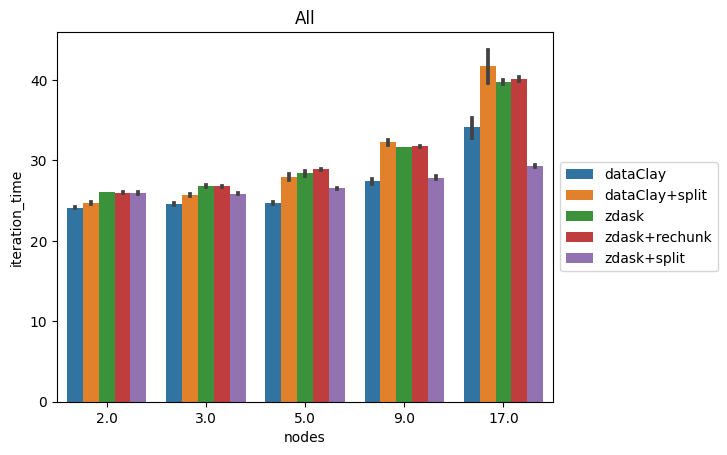

<Figure size 640x480 with 0 Axes>

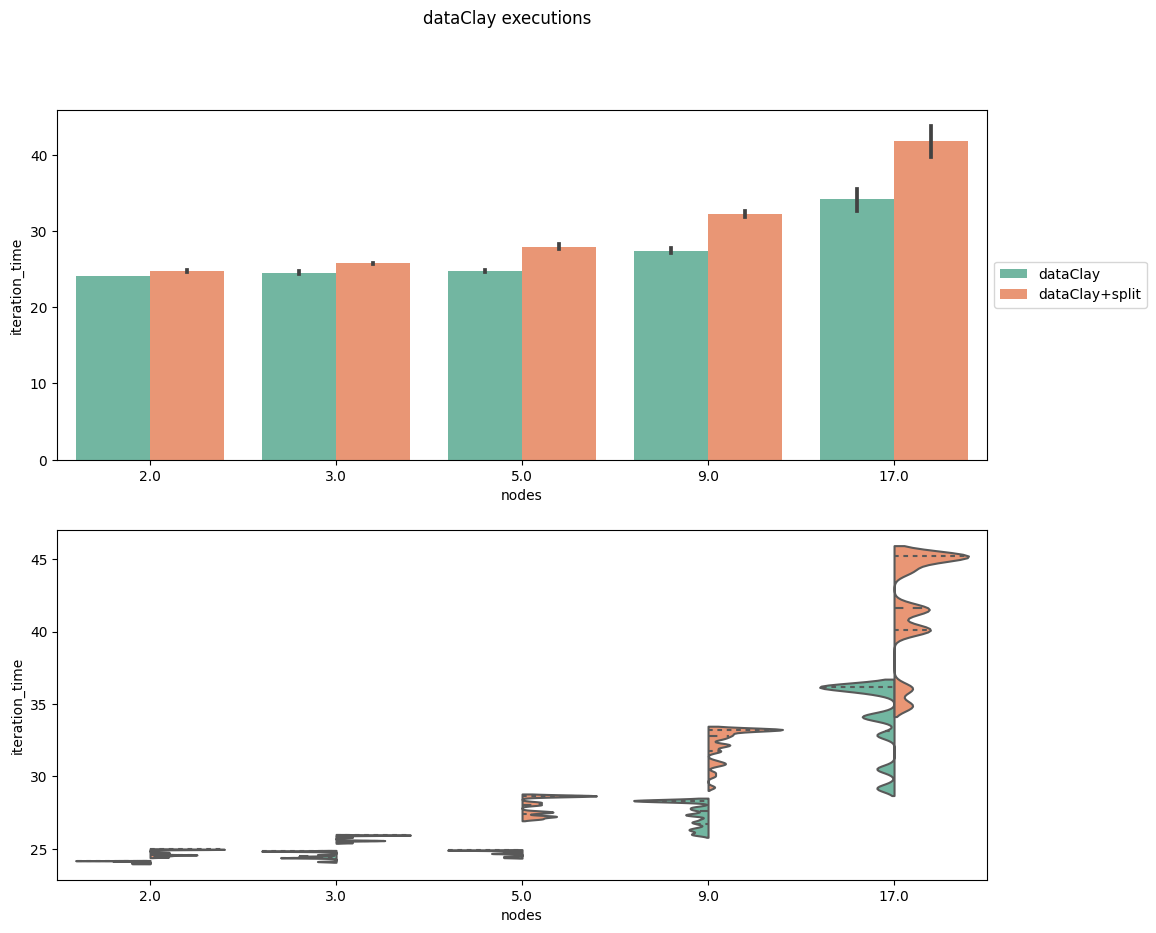

initialization_time  iteration_time
nodes mode                                               
2.0   dataClay                  69.635622       24.129196
      dataClay+split            70.360633       24.722910
      zdask                      2.040138       26.068731
      zdask+rechunk              2.021858       26.000917
      zdask+split                2.041815       25.944466
3.0   dataClay                  83.182684       24.558855
      dataClay+split            83.664813       25.744328
      zdask                      2.238088       26.785163
      zdask+rechunk              2.363634       26.779251
      zdask+split                2.046881       25.877055
5.0   dataClay                 140.139650       24.746518
      dataClay+split           140.804705       27.952540
      zdask                      2.233250       28.492033
      zdask+rechunk              2.344269       28.887602
      zdask+split                2.303490       26.556661
9.0   dataClay                 261.204072       27.433121
      dataClay+split           262.948461       32.278880
      zdask                      2.489963       31.680818
      zdask+rechunk              2.505242       31.746306
      zdask+split                2.317492       27.858061
17.0  dataClay                 507.322544       34.146155
      dataClay+split           507.590789       41.760836
      zdask                      2.641875       39.752341
      zdask+rechunk              2.629592       40.116946
      zdask+split                2.440972       29.353119

In [5]:
# Weak scaling, with big blocks (48 blocks per node)
data = edf.query("((number_of_fragments / (nodes - 1)) == 48) and ((points_per_fragment) == (64000 * 48))")
big_blocks_data = data.copy()
big_blocks_data["nodes"] -= 1

plot_things(data, "iteration_time")

data = data.drop(data.columns.difference(["nodes", "mode", "initialization_time","iteration_time"]), axis="columns")
data.groupby(["nodes", "mode"]).mean()

## Blocksize sweep

8 worker nodes, analyze multiple block sizes (from 128000 points per block to 48 blocks per node). Those are the scenarios of weak scaling (see previous experiments).

In [6]:
# Weak scaling, with big blocks (48 blocks per node)
data = edf.query("(nodes == 9) and ((number_of_fragments * points_per_fragment) == 1179648000)")

def eval_granularity_index(row):
    row["granularity_index"] = row["number_of_fragments"] // (48 * 8)
    return row

data = data.apply(eval_granularity_index, axis=1)
sweep_data = data.copy()

/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


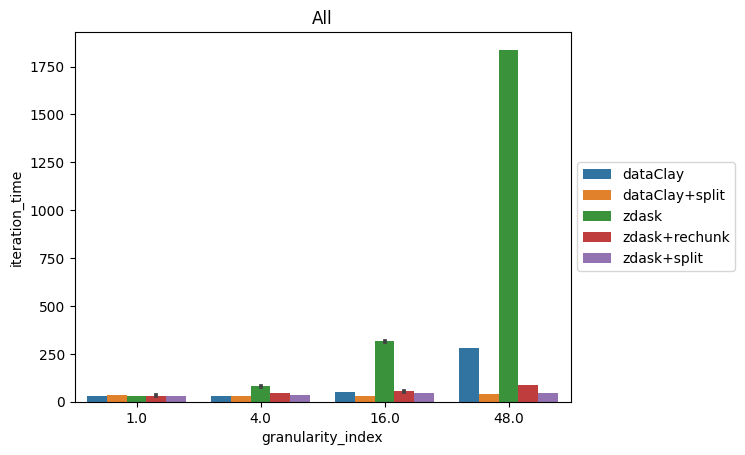

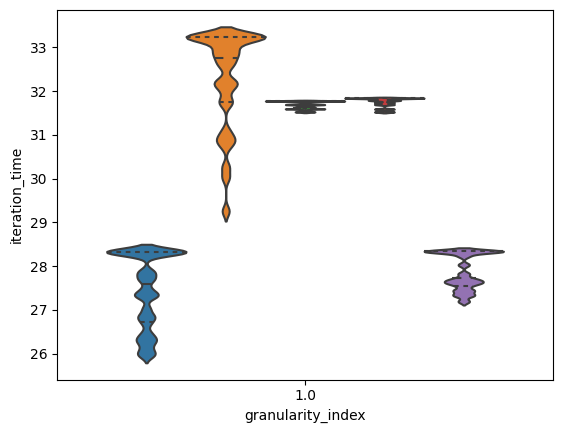

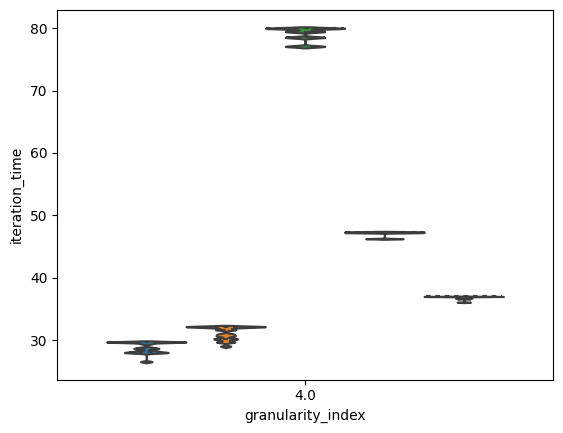

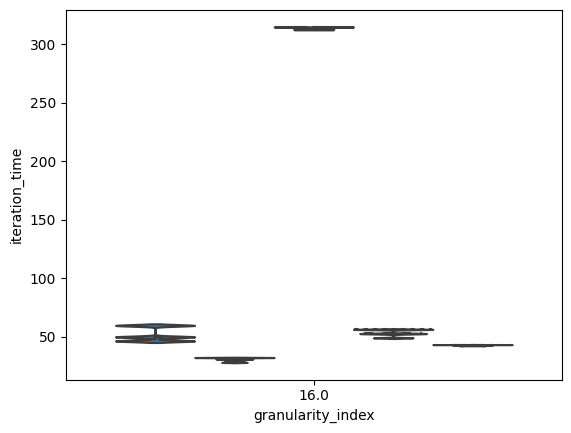

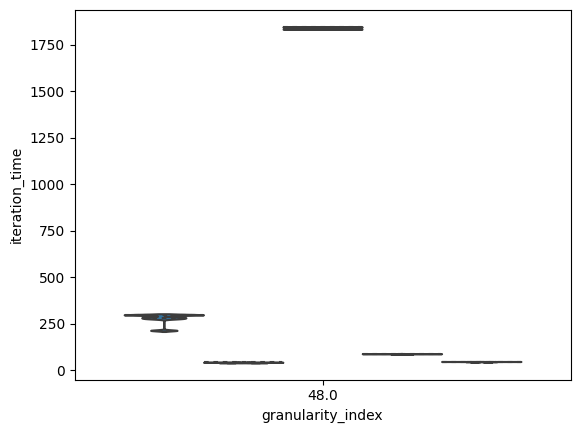

/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


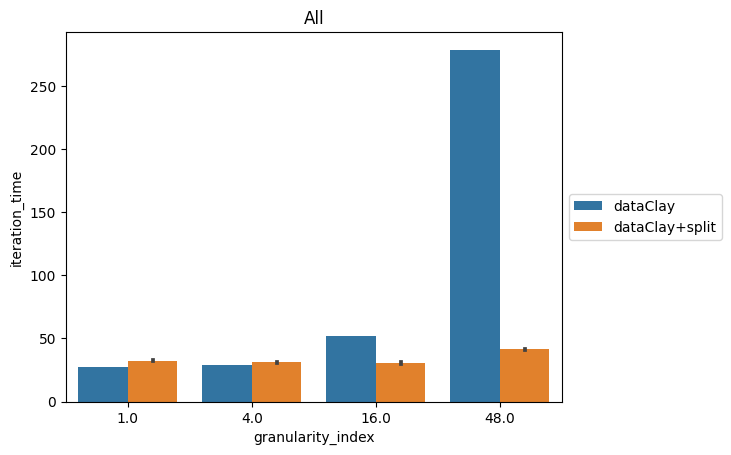

initialization_time  iteration_time
granularity_index mode                                               
1.0               dataClay                 261.204072       27.433121
                  dataClay+split           262.948461       32.278880
                  zdask                      2.489963       31.680818
                  zdask+rechunk              2.505242       31.746306
                  zdask+split                2.317492       27.858061
4.0               dataClay                 258.181876       28.782727
                  dataClay+split           261.353496       31.152987
                  zdask                      2.753413       79.005722
                  zdask+rechunk              2.709660       47.068666
                  zdask+split                2.590562       36.803979
16.0              dataClay                 258.061558       51.863610
                  dataClay+split           260.351928       30.580591
                  zdask                      3.881779      313.930333
                  zdask+rechunk              3.983939       53.279858
                  zdask+split                3.985646       42.723540
48.0              dataClay                 322.611034      278.632099
                  dataClay+split           265.290424       41.423162
                  zdask                      7.020823     1838.948725
                  zdask+rechunk              7.135400       88.327631
                  zdask+split                8.523644       46.259171

In [7]:
sns.barplot(data=data, x="granularity_index", hue="mode", y="iteration_time", 
            estimator=ESTIMATOR_TO_USE)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("All")
# TODO: Change granularity_index to: fragments per core [o algo així]
plt.show()

for i in [1, 4, 16, 48]:
    ax = sns.violinplot(data=data.query("granularity_index == %d" % i),
                        x="granularity_index", hue="mode", y="iteration_time", 
                        scale='width', bw=VIOLIN_BW,
                        inner="quartile", figsize=123)
    ax.get_legend().remove()
    plt.show()

sns.barplot(data=data.query("dataclay == 1"), x="granularity_index", hue="mode", y="iteration_time", 
            estimator=ESTIMATOR_TO_USE)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("All")
plt.show()

data = data.drop(data.columns.difference(["granularity_index", "mode", "initialization_time","iteration_time"]), axis="columns")
data.groupby(["granularity_index", "mode"]).mean()


# Figure generation

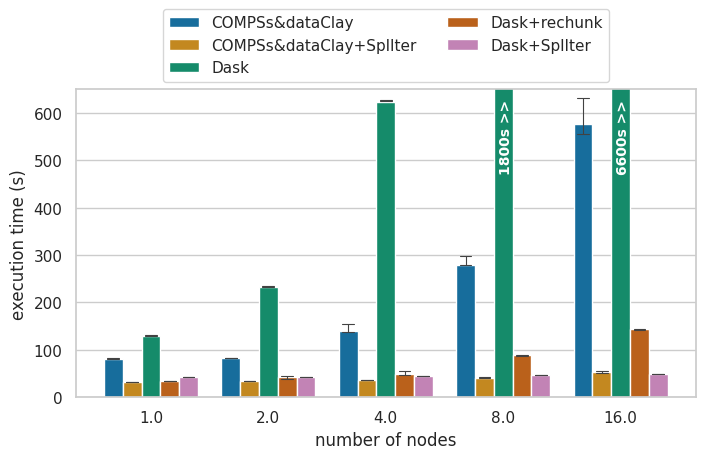

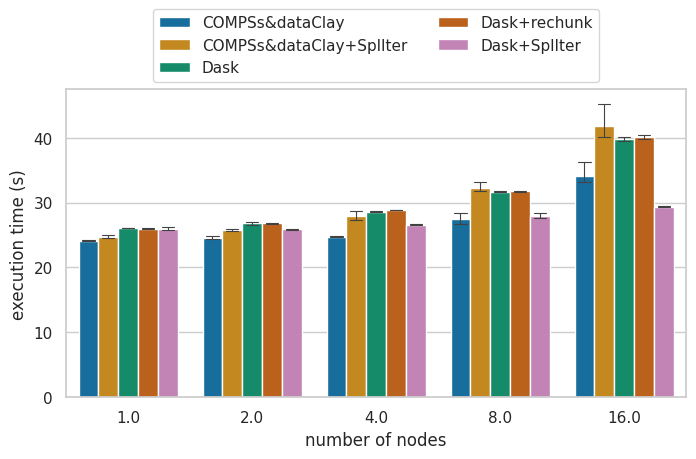

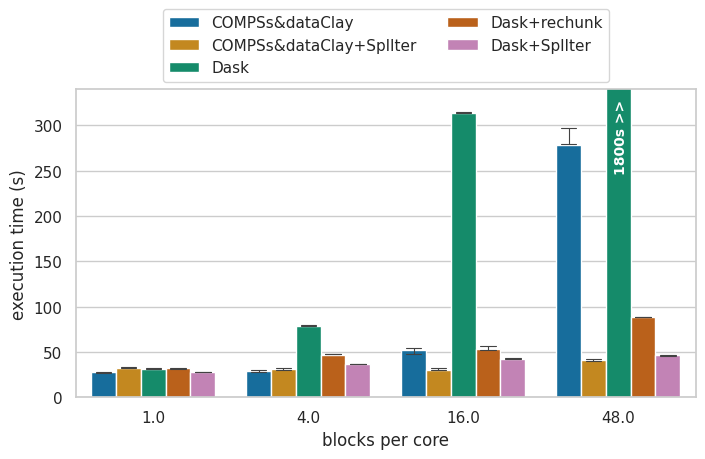

In [8]:
sns.set(style="whitegrid", color_codes=True)

hue_order=["dataClay", "dataClay+split", "zdask", "zdask+rechunk", "zdask+split"]

ax = sns.barplot(y="iteration_time", x="nodes", hue="mode",
                 data=small_blocks_data,
                 capsize=0.1,
                 errwidth=0.8,
                 errorbar=("pi", 50),
                 hue_order=hue_order,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
#ax.legend(h, ["COMPSs", "COMPSs+dataClay", "COMPSs+dataClay+split", "dask", "dask+rechunk", "dask+split"])
ax.legend(h, ["COMPSs&dataClay", "COMPSs&dataClay+SplIter", "Dask", "Dask+rechunk", "Dask+SplIter"])
ax.set_ylabel("execution time (s)")
ax.set_xlabel("number of nodes")

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=True,
)


# Special case: let's force the y_lim and let's write the value inside the bar
ax.set_ylim([0, 650])
#ax.text(3.69, 760, "4200s >>", ha="center", va="top", rotation=90, color="white", weight="semibold", fontsize=10)
ax.text(3.02, 650, "1800s >>  ", ha="center", va="top", rotation=90, color="white", weight="semibold", fontsize=10)
ax.text(4.02, 650, "6600s >>  ", ha="center", va="top", rotation=90, color="white", weight="semibold", fontsize=10)
for idx, rect in enumerate(ax.plot()):
    print(idx)

save_tweaks("kmeans-weakscaling_smallblocks.pdf")
plt.show()

ax = sns.barplot(y="iteration_time", x="nodes", hue="mode",
                 data=big_blocks_data,
                 capsize=0.1,
                 errwidth=0.8,
                 errorbar=("pi", 50),
                 hue_order=hue_order,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
#ax.legend(h, ["COMPSs", "COMPSs+dataClay", "COMPSs+dataClay+split", "dask", "dask+rechunk", "dask+split"])
ax.legend(h, ["COMPSs&dataClay", "COMPSs&dataClay+SplIter", "Dask", "Dask+rechunk", "Dask+SplIter"])
ax.set_ylabel("execution time (s)")
ax.set_xlabel("number of nodes")

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=True,
)

save_tweaks("kmeans-weakscaling_bigblocks.pdf")
plt.show()

ax = sns.barplot(y="iteration_time", x="granularity_index", hue="mode",
                 data=sweep_data,
                 capsize=0.1,
                 errwidth=0.8,
                 errorbar=("pi", 50),
                 hue_order=hue_order,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
#ax.legend(h, ["COMPSs", "COMPSs+dataClay", "COMPSs+dataClay+split", "dask", "dask+rechunk", "dask+split"])
ax.legend(h, ["COMPSs&dataClay", "COMPSs&dataClay+SplIter", "Dask", "Dask+rechunk", "Dask+SplIter"])
ax.set_ylabel("execution time (s)")
ax.set_xlabel("blocks per core")

ax.set_ylim([0, 340])
ax.text(3.02, 340, "1800s >>  ", ha="center", va="top", rotation=90, color="white", weight="semibold", fontsize=10)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=True,
)

save_tweaks("kmeans-blocksweep.pdf")
plt.show()


/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/alex/BSC/split-miniapps/venv/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


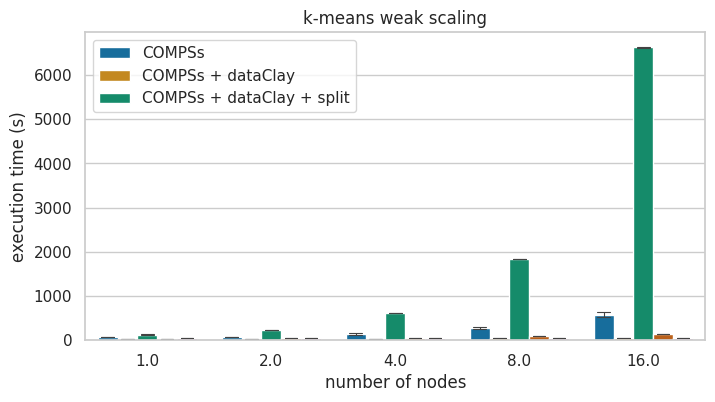

In [9]:
ax = sns.barplot(y="iteration_time", x="nodes", hue="mode",
                 data=small_blocks_data,
                 capsize=0.1,
                 errwidth=0.8,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["COMPSs", "COMPSs + dataClay", "COMPSs + dataClay + split"])
ax.set_title("k-means weak scaling")
ax.set_ylabel("execution time (s)")
ax.set_xlabel("number of nodes")

save_tweaks("kmeans-anotherpresentation.png")
plt.show()
